<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/Detecting_Anomalies_In_Natural_Gas_Prices_Using_Deep_Learning3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Problem statement**

This project aims to Natural Gas data from 1997-01-07 - 2023-07-24 using anomaly detection techniques to uncover hidden patterns and outliers in the data. We will use the Pytorch library in Python to construct and train a model to detect anomalous data points within the dataset. Finally, we will analyze and interpret our results to draw meaningful conclusions about the Crude oil market.

In [ ]:
!nvidia-smi

Sat Sep 16 02:14:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install chart_studio
!pip install plotly==4.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 7.8 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0


In [ ]:
# Check for GPU
import torch
torch.cuda.is_available()

True

#### Importing the relevant libraries

In [ ]:
from pandas import read_csv
import plotly
import plotly.express as px
import chart_studio.plotly as py
#import cufflinks as cf
from plotly.offline import init_notebook_mode, iplot
#init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
#offline.init_notebook_mode()
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from datetime import date, timedelta # Date Operations
import matplotlib.pyplot as plt # To aid in visualizing
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates # Date formatting
# sets the random number seed to ensure reproducible results
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
#torch.manual_seed(RANDOM_SEED)

####Loading the dataset

In [ ]:
path ='https://raw.githubusercontent.com/mofuoku417/anomaly-detection/main/Data/HHD.csv'
df = read_csv(path, parse_dates=['Date'])
df.head(6)

,Date,hh_sp
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00
5,1997-01-14,4.01


In [ ]:
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6676 entries, 0 to 6675
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6676 non-null   datetime64[ns]
 1   hh_sp   6675 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 104.4 KB


###Data Preprocessing

### Displaying the timeseries

In [ ]:
trace_hh_sp = go.Scatter(
    x = df["Date"],
    y = df["hh_sp"],
    mode = 'lines',
    name="hh_sp"
)
data = [trace_hh_sp]

layout = go.Layout(title="Daily Henry Hub Natural Gas Spot Price (Dollars per Million Btu)", xaxis=dict(title="Date"), yaxis=dict(title="Henry Hub Daily Natural Gas Prices") )

#layout = go.Layout(title="Daily Henry Hub Natural Gas Spot Price (Dollars per Million Btu)",xaxis_rangeslider_visible=True)
fig = go.Figure(data=data,layout=layout)

fig.update_xaxes(range=["1997-01","2023-08"])
fig.update_layout(xaxis=dict(tickformat="%Y-%m-%d"))

plotly.offline.iplot(fig)
fig.show(renderer="colab")

### Removing Missing Data

In [ ]:
print(df.isnull().sum())
print('Old size %d'% len(df))
df2 = df.dropna(how='any',axis='rows')
print('New size %d' % len(df2))
df2.head()
df3 = df2.copy

Date     0
hh_sp    1
dtype: int64
Old size 6676
New size 6675


Deviation from established pattern is considered an anomaly in a given data. Apply a Boxplot to visualize these deviations.

In [ ]:
fig = px.box(df2, y="hh_sp", title='Daily Henry Hub Natural Gas Price 1986-2000')
fig.show(renderer="colab")

In [ ]:
df2 = df2.set_index('Date').sort_index()
train = df2[:'2021-01-01']
test = df2['2021-01-01':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (6034, 1)
Test dataset shape: (641, 1)


### Standardize the Data

In [ ]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_train = scaler_X.fit_transform(train)
y_train = scaler_Y.fit_transform(train)
X_test = scaler_X.transform(test)
y_test = scaler_Y.transform(test)

In [ ]:
X_train, X_val = train_test_split(X_train, test_size = 0.15, random_state=RANDOM_SEED)
print(X_train.shape, X_val.shape,X_test.shape)

(5128, 1) (906, 1) (641, 1)


In [ ]:
train_sequence  = X_train.astype(np.float32).tolist()
val_sequence = X_val.astype(np.float32).tolist()
test_sequence = X_test.astype(np.float32).tolist()

In [ ]:
def create_dataset(sequences):
    dataset = [torch.tensor(s).unsqueeze(1) for s in sequences]

    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_sequence)
val_dataset, _, _ = create_dataset(val_sequence)
test_dataset, _, _ = create_dataset(test_sequence)

### Building the LSTM Autoencoder

In [ ]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=self.embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return hidden_n

class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, 1, 1)
    x = x.permute(1, 0, 2)
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    print("Inputs size:", x.size())
    x = self.encoder(x)
    print("Representation size: ", x.size())
    x = self.decoder(x)
    print("Outputs size: ", x.size())
    return x

batch_n = 1 # 5
seq_len = 1 # 10
n_features = 1
inputs = torch.randn(batch_n, seq_len, n_features).to(device)

model = RecurrentAutoencoder(seq_len, n_features).to(device)
y = model(inputs)

Inputs size: torch.Size([1, 1, 1])
Representation size:  torch.Size([1, 1, 64])
Outputs size:  torch.Size([1, 1, 1])


In [ ]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features):
        super(Encoder, self).__init__()

        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = 2 * args.embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=args.n_layers,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=args.embedding_dim,
          num_layers=args.n_layers,
          batch_first=True
        )

    def forward(self, x):
      x = x.reshape((args.batch_size, self.seq_len, self.n_features))
      x, (_, _) = self.rnn1(x)
      x, (hidden_n, _) = self.rnn2(x)
      return hidden_n.reshape((self.n_features, args.embedding_dim))

In [ ]:
class Decoder(nn.Module):
    def __init__(self, seq_len, n_features):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.hidden_dim = 2 * args.embedding_dim
        self.n_features = n_features

        self.rnn1 = nn.LSTM(
        input_size=args.embedding_dim,
        hidden_size=args.embedding_dim,
        num_layers=args.n_layers,
        batch_first=True
        )
        self.rnn2 = nn.LSTM(
        input_size=args.embedding_dim,
        hidden_size=self.hidden_dim,
        num_layers=args.n_layers,
        batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, args.batch_size)

        x = x.reshape((n_features, self.seq_len, args.embedding_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features):
        super(RecurrentAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features

        self.encoder = Encoder(seq_len, n_features).to(args.device)
        self.decoder = Decoder(seq_len, n_features).to(args.device)
    def forward(self, x):
        x = self.encoder(x)

        x = self.decoder(x)
        return x

In [ ]:
def train_model(train_dataset, val_dataset, n_epochs):
    model = RecurrentAutoencoder(seq_len, n_features)
    model = model.to(args.device)

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    criterion = nn.L1Loss(reduction='sum').to(args.device)

    history = dict(train=[], val=[])

    for epoch in range(1 , n_epochs + 1):
        model = model.train()
        ts = time.time()
        train_losses = []

        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(args.device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(args.device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)

                val_losses.append(loss.item())
        te = time.time()
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)

        print(f"Epoch: {epoch}  train loss: {train_loss}  val loss: {val_loss}  time: {te-ts} ")

        return model.eval(), history

In [ ]:
from argparse import ArgumentParser
import argparse
import time
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

#parser = ArgumentParser()
parser = argparse.ArgumentParser(
                    prog='ProgramName',
                    description='What the program does',
                    epilog='Text at the bottom of help')

args = parser.parse_args('')

args.device = 'cuda' if torch.cuda.is_available else 'cpu'

args.batch_size = 1

args.n_layers = 1
args.embedding_dim = 64


args.dropout = 0
args.use_bn = False

args.lr = 0.001
args.epoch = 100

#model, history = train_model(train_dataset, val_dataset, args.epoch)

In [ ]:
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(args.device)

    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(args.device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

In [ ]:
_, losses = predict(model, train_dataset)

Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
I

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning:

Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Streaming output truncated to the last 5000 lines.
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torc

<ipython-input-27-3228f938f381>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: ylabel='Density'>

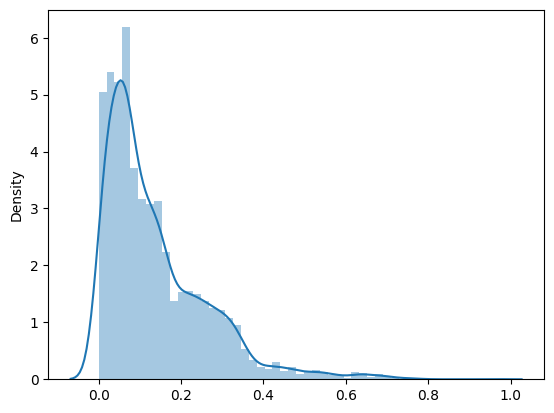

In [ ]:
sns.distplot(losses, bins=50, kde=True)

Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
I

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning:

Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
R

<Axes: ylabel='Count'>

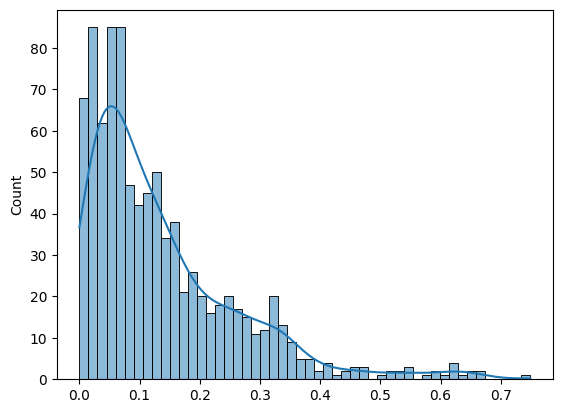

In [ ]:
predictions, val_losses = predict(model, val_dataset)
sns.histplot(val_losses, bins=50, kde= True)

Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
I

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning:

Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
Representation size:  torch.Size([1, 64])
Outputs size:  torch.Size([1, 1, 1])
Inputs size: torch.Size([1, 1])
R

<ipython-input-29-3c40890f27e1>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: ylabel='Density'>

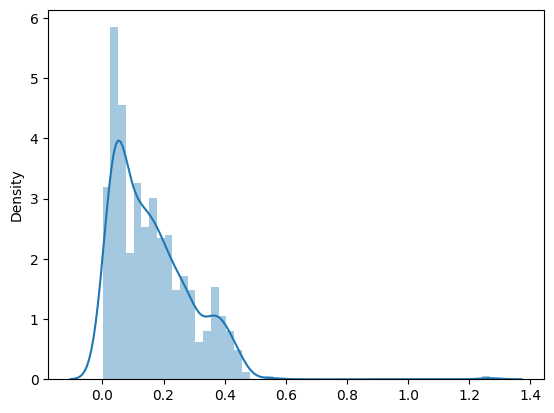

In [ ]:
predictions, pred_losses = predict(model, test_dataset)
sns.distplot(pred_losses,bins=50, kde= True)

Threshold =  0.6

In [ ]:
total_losses = losses + val_losses + pred_losses
Threshold = 0.6

### Creating DataFrame of losses

In [ ]:
test_score_df = pd.DataFrame(index = df2.index)
test_score_df['loss'] = total_losses
test_score_df['threshold'] = Threshold
#test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold

test_score_df['anomaly'] = test_score_df['loss'].apply(lambda dev: 1 if dev > Threshold else 0)

anomalies = test_score_df[test_score_df['anomaly'] == 1]

not_anomalies = test_score_df[test_score_df['anomaly'] == 0]

print(f'Total normal: {not_anomalies.shape[0]}')
print(f'Total anomalies: {anomalies.shape[0]}')

#test_score_df['price'] = test.hh_sp


Total normal: 6612
Total anomalies: 63


In [ ]:
# Show the identified anomalies
anomalies.head(5)

,loss,threshold,anomaly
Date,,,
1997-07-08,0.716324,0.6,1
1997-09-02,0.683049,0.6,1
1998-01-27,0.602729,0.6,1
1998-01-28,0.676738,0.6,1
1998-04-03,0.628546,0.6,1


###  Displaying the detected anomalies distribution

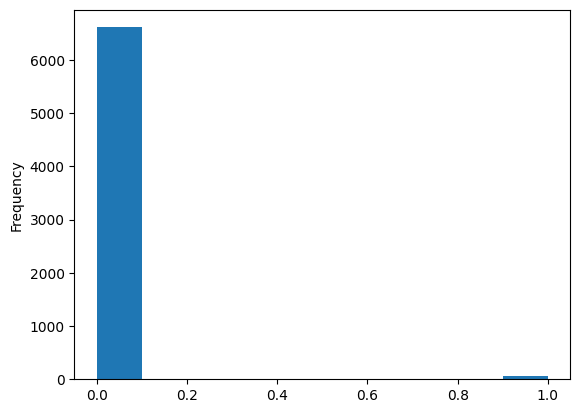

In [ ]:
distribution:test_score_df['anomaly'].plot(kind='hist')

### Displaying the loss versus threshold

In [ ]:
#score.reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.index, y=(test_score_df.loss), mode='lines', name='Loss'))
fig.add_trace(go.Scatter(x=test_score_df.index, y=(test_score_df.threshold), mode='lines', name='Threshold'))
fig.update_xaxes(range=["1997-01","2023-08"])
fig.update_layout(xaxis=dict(tickformat="%Y-%m-%d"))
fig.update_layout(showlegend=True)
fig.show(renderer="colab")

In [ ]:
'''
A = anomalies2.price

A.values

# converting 1-D array to 2-D array
#A.reshape(1,-1)

A.to_numpy().reshape(-1, 1)
'''

'\nA = anomalies2.price\n\nA.values\n\n# converting 1-D array to 2-D array\n#A.reshape(1,-1)\n\nA.to_numpy().reshape(-1, 1)\n'